In [96]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
from nltk import pos_tag, pos_tag_sents
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [97]:
file = pd.read_csv('../Campaign Type.csv', sep='|')
file = file.loc[:,['Campaign','Product Type','Subject Line','Sent','Unique Open','Unique Click']]
file.columns = ['campaign', 'prod_type', 'subject', 'sent', 'uniq_open', 'uniq_click']

In [98]:
file['openrate%'] = 100*(file['uniq_open'] / file['sent'])
file['clickrate%'] = 100*(file['uniq_click'] / file['sent'])

In [99]:
def count_pos(df, pos_type):
    nouns = ['NN','NNS','NNP','NNPS']
    verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
    adverbs = ['RB','RBR','RBS']
    adjectives = ['JJ','JJR','JJS']
    
    d = dict(pos_tag(df['subject'].split(',')))
    pos_values = list(d.values())
    cnt = 0
    
    if pos_type == 'noun':
        for each in pos_values:
            if each in nouns:
                cnt += 1
    elif pos_type == 'verb':
        for each in pos_values:
            if each in verbs:
                cnt += 1
    elif pos_type == 'adv':
        for each in pos_values:
            if each in adverbs:
                cnt += 1
    elif pos_type == 'adj':
        for each in pos_values:
            if each in adjectives:
                cnt += 1
    else:
        pass
    return cnt

class processing(TransformerMixin):
    """
    [mandatory] make sure the df has 'subject' field
    [optional] 'campaign' and/or 'prod_type' fields
    """
    def __init__(self, df):
        self.df = df
        
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        stop_words = set(stopwords.words('english'))

        df['subject'] = df['subject'].apply(''.join).str.replace('[^A-Za-z\d!?\s]+', '').str.split(expand=False)
        df['subject'] = df['subject'].apply(lambda x: ','.join([w for w in x if not w in stop_words]))

        df.loc[:, 'word_count'] = df.apply(lambda x: len(x['subject'].split(',')), axis = 1)
        df.loc[:, 'char_len'] = df.apply(lambda x: len(x['subject']), axis = 1)
        df.loc[:, 'avg_word_len'] = df['char_len'] / df['word_count']
        df.loc[:, 'mentioned_amt'] = df.apply(lambda x: len(re.findall("Rs\d+", x['subject'])), axis = 1)
        df.loc[:, 'mentioned_Indus'] = df.apply(lambda x: len(re.findall("indus*", x['subject'].lower())), axis = 1)
        df.loc[:, 'nouns'] = df.apply(lambda x: count_pos(x, pos_type='noun'), axis = 1)
        df.loc[:, 'verbs'] = df.apply(lambda x: count_pos(x, pos_type='verbs'), axis = 1)
        df.loc[:, 'adverbs'] = df.apply(lambda x: count_pos(x, pos_type='adverbs'), axis = 1)
        df.loc[:, 'adjectives'] = df.apply(lambda x: count_pos(x, pos_type='adjectives'), axis = 1)

        df = df.drop(['char_len'], axis = 1)

        le = LabelEncoder()
        cols = list(df.columns)
        if 'campaign' in cols:
            df['campaign'] = le.fit_transform(df['campaign'])
        if 'prod_type' in cols:
            df['prod_type'] = le.fit_transform(df['prod_type'])

    #     df = df.drop_duplicates()

        return df

In [100]:
def get_doc(df):
        df = df[['subject']]
        taggeddoc = []
        texts = []

        for i, row in file.iterrows():
            #for tagged doc
            wordslist = []
            tagslist = []

            td = TaggedDocument(gensim.utils.to_unicode(str.encode(row['subject'])).split(','), [str(i)])
            taggeddoc.append(td)
        return taggeddoc

    
class embedding(TransformerMixin):
    """
    sentence embedding - currently doc2vec
    [mandatory] make sure df has 'subject' field
    """
    def __init__(self, df):
        self.df = df
        
    def fit(self, *_):
        return self

    def transform(df, *_):
        documents = get_doc(df)

        vec_dim_size = 20
        d2v = Doc2Vec(documents=documents, dm = 0, alpha=0.025, size=vec_dim_size, min_alpha=0.025, min_count=1)

        for epoch in range(200):
            if epoch % 20 == 0:
                print('...training epoch %s'%epoch)
            d2v.train(documents, total_examples = len(documents), epochs=1)
            d2v.alpha -= 0.002 # decreasing the lr
            d2v.min_alpha = d2v.alpha # fix the lr, no decay

        sub_d2v_df = pd.DataFrame(d2v.docvecs.vectors_docs)
        cols = ['s'+str(i) for i in range(vec_dim_size)]
        sub_d2v_df.columns = cols

        tmp_df = df.drop(['subject','sent','uniq_open','uniq_click','clickrate%'], axis = 1)
        df_cols = list(tmp_df.columns)
        if 'campaign' in df_cols: # remove 'campaign' col (if present)
            tmp_df = tmp_df.drop(['campaign'], axis = 1)
        if 'prod_type' in df_cols: # remove 'prod_type' col (if present)
            tmp_df = tmp_df.drop(['prod_type'], axis = 1)

        #concat d2v df and processed df
        sub_df = pd.concat([sub_d2v_df, tmp_df], axis = 1)

        return sub_df

In [101]:
class splitter(TransformerMixin):
    
    def __init__(self, df):
        self.df = df
    
    def fit(self, *_):
        return self
    
    def transform(df, *_):
        X = df.drop(['openrate%'], axis = 1)
        y = df[['openrate%']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        return X_train, X_test, y_train, y_test

In [106]:
pipe = Pipeline([('processing', processing),
                 ('embedding', embedding),
                 ('splitter', splitter)])#,
#                  ('rfr', RandomForestRegressor(n_estimators=10))])

In [107]:
R = pipe.transform(file)

...training epoch 0
...training epoch 20
...training epoch 40
...training epoch 60
...training epoch 80
...training epoch 100
...training epoch 120
...training epoch 140
...training epoch 160
...training epoch 180


In [108]:
X_train, X_test, y_train, y_test = R
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3430, 28)
(3430, 1)
(1470, 28)
(1470, 1)


Training set score: 0.84
Test set score: 0.11
------------------------------
MSE: 0.04206563208902949
------------------------------


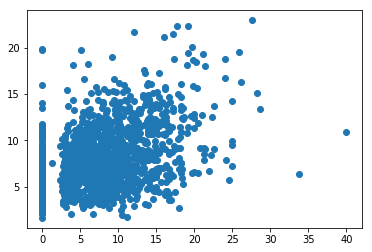

,features,feature_imp
21,avg_word_len,0.221923
8,s8,0.058468
0,s0,0.053803
11,s11,0.053712
16,s16,0.052011
13,s13,0.049513
5,s5,0.044356
1,s1,0.043667
18,s18,0.041237
4,s4,0.038963


In [111]:
rfr = RandomForestRegressor(n_estimators=10)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
print('-'*30)
print("MSE: {}".format(np.mean(y_test.values - y_pred.ravel()) ** 2))
print('-'*30)

plt.scatter(y_test, y_pred)
plt.show()

features = X_train.columns.tolist()

feat_imp = pd.DataFrame({"features": features, "feature_imp": rfr.feature_importances_}).sort_values("feature_imp", ascending=False)
feat_imp.head(10)

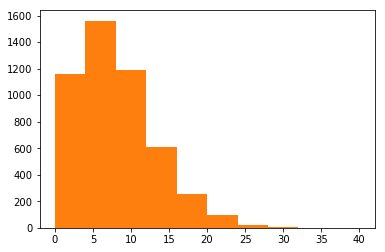

In [43]:
# distribution of y label
plt.hist(y.values, bins=10)
plt.show()